In [4]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report
from catboost import CatBoostClassifier, Pool


def make_path(begin: str, end: str) -> str:
    return os.path.join(os.path.abspath(begin), end)


def geo_key(name: str) -> str:
    n = name.lower()
    if "depart" in n:
        return "DEP"
    if "region" in n:
        return "Reg"
    return "INSEE"


class initial_data:
    def __init__(self, dataset: dict, geography: dict, is_train: bool, data_dir: str):
        self.is_train = is_train
        self.data_dir = os.path.abspath(data_dir)

        for var, item in dataset.items():
            setattr(self, var, pd.read_csv(make_path(self.data_dir, item), low_memory=False))
        for var, item in geography.items():
            setattr(self, var, pd.read_csv(make_path(self.data_dir, item), low_memory=False))

        self.main = getattr(self, list(dataset.keys())[0]).copy()
        for var in list(dataset.keys())[1:]:
            self.main = self.main.merge(getattr(self, var), on="UID", how="left")

        for geog in geography.keys():
            geo_df = getattr(self, geog)
            key = geo_key(geog)
            if key in self.main.columns and key in geo_df.columns:
                self.main = self.main.merge(geo_df, on=key, how="left")

        for dest, cat in {"is_retiree": "retired_jobs", "is_sport_member": "sport"}.items():
            if hasattr(self, cat) and "UID" in getattr(self, cat).columns:
                self.main[dest] = self.main["UID"].isin(getattr(self, cat)["UID"]).astype(int)
            else:
                self.main[dest] = 0

        x_cols = [c for c in self.main.columns if c.endswith("_x")]
        for c in x_cols:
            y_col = c.replace("_x", "_y")
            if y_col in self.main.columns:
                m = self.main[c].isna()
                self.main.loc[m, c] = self.main.loc[m, y_col]

        self.main = self.main.loc[:, [not c.endswith("_y") for c in self.main.columns]]
        self.main.columns = [c.replace("_x", "") for c in self.main.columns]
        self.main = self.main.drop(["X", "Y", "LAT", "Long"], axis=1, errors="ignore")

        self.y = None
        self.UID = None
        self.cat_cols = None
        self.cat_idx = None

    def check_if_train(func):
        def wrapper(self, *args, **kwargs):
            if not self.is_train:
                raise RuntimeError("Impossible on test Dataset")
            return func(self, *args, **kwargs)
        return wrapper

    def preprocessing(self, cat_cols=None):
        if self.is_train:
            self.y = self.main["target"].astype("string").fillna("__MISSING_TARGET__")
            self.main = self.main.drop(columns=["target"])
        else:
            self.UID = self.main["UID"].copy()

        self.main = self.main.drop(columns=["UID"])

        if cat_cols is None:
            cat_cols = self.main.select_dtypes(include=["object"]).columns.tolist()
            for c in ["INSEE", "DEP", "Reg", "job_dep", "JOB_SECURITY", "Sports"]:
                if c in self.main.columns and c not in cat_cols:
                    cat_cols.append(c)

        for c in cat_cols:
            if c in self.main.columns:
                self.main[c] = self.main[c].astype("string").fillna("__MISSING__")

        self.cat_cols = cat_cols
        self.cat_idx = [self.main.columns.get_loc(c) for c in cat_cols if c in self.main.columns]
        return self.cat_cols, self.cat_idx

    @check_if_train
    def search_grid(self):
        grid = [{"depth": d, "learning_rate": lr, "l2_leaf_reg": l2}
                for d in [6, 8] for lr in [0.05, 0.1] for l2 in [3, 7]]

        classes = sorted(self.y.astype(str).unique().tolist())
        cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=66)

        results = []
        for g in grid:
            accs, f1s, lls = [], [], []
            for tr, va in cv.split(self.main, self.y):
                train_pool = Pool(self.main.iloc[tr], self.y.iloc[tr], cat_features=self.cat_idx)
                valid_pool = Pool(self.main.iloc[va], self.y.iloc[va], cat_features=self.cat_idx)

                model = CatBoostClassifier(
                    loss_function="Logloss",
                    iterations=500,
                    od_type="Iter",
                    od_wait=50,
                    random_seed=66,
                    thread_count=-1,
                    verbose=False,
                    **g
                )
                model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

                pred = model.predict(valid_pool).astype(str).ravel()
                proba = model.predict_proba(valid_pool)
                y_true = self.y.iloc[va].astype(str).values

                accs.append(accuracy_score(y_true, pred))
                f1s.append(f1_score(y_true, pred, average="macro"))
                lls.append(log_loss(y_true, proba, labels=classes))

            row = {
                **g,
                "cv_acc_mean": float(np.mean(accs)),
                "cv_f1_macro_mean": float(np.mean(f1s)),
                "cv_logloss_mean": float(np.mean(lls)),
            }
            results.append(row)
            print(f"Done {g} | F1={row['cv_f1_macro_mean']:.4f} "
                  f"ACC={row['cv_acc_mean']:.4f} LogLoss={row['cv_logloss_mean']:.4f}")

        res_df = pd.DataFrame(results).sort_values(
            by=["cv_f1_macro_mean", "cv_logloss_mean"],
            ascending=[False, True]
        ).reset_index(drop=True)

        res_df.to_csv("grid_results.csv", index=False)

        best = res_df.iloc[0].to_dict()
        best_params = {
            "depth": int(best["depth"]),
            "learning_rate": float(best["learning_rate"]),
            "l2_leaf_reg": float(best["l2_leaf_reg"]),
        }
        return best_params

    @check_if_train
    def get_train_split(self):
        return train_test_split(self.main, self.y, test_size=0.2, random_state=66, stratify=self.y)


DATA_DIR = "Data"

learning_vars = {
    "main": "learn_dataset.csv",
    "job": "learn_dataset_job.csv",
    "job_security": "learn_dataset_JOB_SECURITY.csv",
    "retired_pension": "learn_dataset_retired_pension.csv",
    "retired_jobs": "learn_dataset_retired_jobs.csv",
    "sport": "learn_dataset_sport.csv",
}
test_vars = {
    "main": "test_dataset.csv",
    "job": "test_dataset_job.csv",
    "job_security": "test_dataset_JOB_SECURITY.csv",
    "retired_pension": "test_dataset_retired_pension.csv",
    "retired_jobs": "test_dataset_retired_jobs.csv",
    "sport": "test_dataset_sport.csv",
}
geography = {
    "city_adm": "city_adm.csv",
    "city_pop": "city_pop.csv",
    "departments": "departments.csv",
    "regions": "regions.csv",
}

learning = initial_data(learning_vars, geography, is_train=True, data_dir=DATA_DIR)
testing = initial_data(test_vars, geography, is_train=False, data_dir=DATA_DIR)

cat_cols, cat_idx = learning.preprocessing()
testing.preprocessing(cat_cols=cat_cols)

best_params = learning.search_grid()

base_params = dict(
    loss_function="Logloss",
    iterations=500,
    od_type="Iter",
    od_wait=50,
    random_seed=66,
    thread_count=-1,
    verbose=False
)
model_params = {**base_params, **best_params}

X_tr, X_va, y_tr, y_va = learning.get_train_split()
tr_pool = Pool(X_tr, y_tr, cat_features=cat_idx)
va_pool = Pool(X_va, y_va, cat_features=cat_idx)

cm_model = CatBoostClassifier(**model_params)
cm_model.fit(tr_pool, eval_set=va_pool, use_best_model=True)

pred_va = cm_model.predict(va_pool).astype(str).ravel()
print(confusion_matrix(y_va.astype(str).values, pred_va))
print(classification_report(y_va.astype(str).values, pred_va))

full_pool = Pool(learning.main, learning.y, cat_features=cat_idx)
test_pool = Pool(testing.main, cat_features=cat_idx)

final_model = CatBoostClassifier(**model_params)
final_model.fit(full_pool)

pred_test = final_model.predict(test_pool).astype(str).ravel()
pd.DataFrame({"UID": testing.UID, "target": pred_test}).to_csv("predictions.csv", index=False)
print("Saved predictions2.csv")


Done {'depth': 6, 'learning_rate': 0.05, 'l2_leaf_reg': 3} | F1=0.6959 ACC=0.6996 LogLoss=0.5667
Done {'depth': 6, 'learning_rate': 0.05, 'l2_leaf_reg': 7} | F1=0.6957 ACC=0.6996 LogLoss=0.5668
Done {'depth': 6, 'learning_rate': 0.1, 'l2_leaf_reg': 3} | F1=0.6969 ACC=0.7003 LogLoss=0.5639
Done {'depth': 6, 'learning_rate': 0.1, 'l2_leaf_reg': 7} | F1=0.6980 ACC=0.7012 LogLoss=0.5643
Done {'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 3} | F1=0.6978 ACC=0.7013 LogLoss=0.5642
Done {'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 7} | F1=0.6968 ACC=0.7004 LogLoss=0.5641
Done {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3} | F1=0.6960 ACC=0.6993 LogLoss=0.5656
Done {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 7} | F1=0.6959 ACC=0.6993 LogLoss=0.5647
[[4082 1209]
 [1667 3052]]
              precision    recall  f1-score   support

           O       0.71      0.77      0.74      5291
           S       0.72      0.65      0.68      4719

    accuracy                         

In [7]:
import pandas as pd

res_df = pd.read_csv("grid_results.csv")

best = res_df.sort_values(
    by=["cv_f1_macro_mean", "cv_logloss_mean"],
    ascending=[False, True]
).iloc[0]

best_params = {
    "depth": int(best["depth"]),
    "learning_rate": float(best["learning_rate"]),
    "l2_leaf_reg": float(best["l2_leaf_reg"]),
}
best_cv = {
    "cv_f1_macro_mean": float(best["cv_f1_macro_mean"]),
    "cv_acc_mean": float(best["cv_acc_mean"]),
    "cv_logloss_mean": float(best["cv_logloss_mean"]),
}

print("BEST PARAMS:", best_params)
print("BEST CV:", best_cv)



BEST PARAMS: {'depth': 6, 'learning_rate': 0.1, 'l2_leaf_reg': 7.0}
BEST CV: {'cv_f1_macro_mean': 0.6979957630764894, 'cv_acc_mean': 0.7012148823082763, 'cv_logloss_mean': 0.5642723365807188}


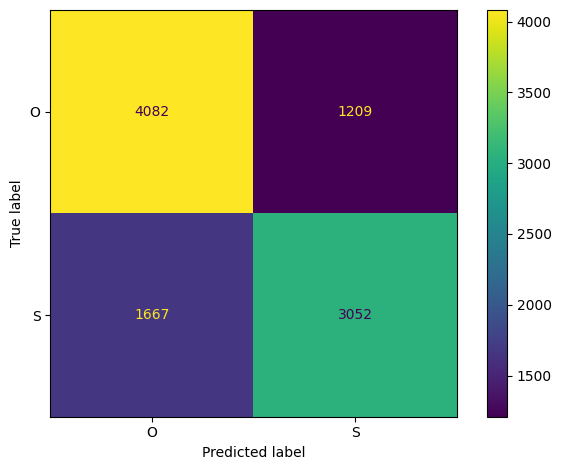

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = y_va.astype(str).values
y_pred = cm_model.predict(X_va).astype(str).ravel() 

disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.tight_layout()
plt.show()


ROC-AUC = 0.7848898694416813


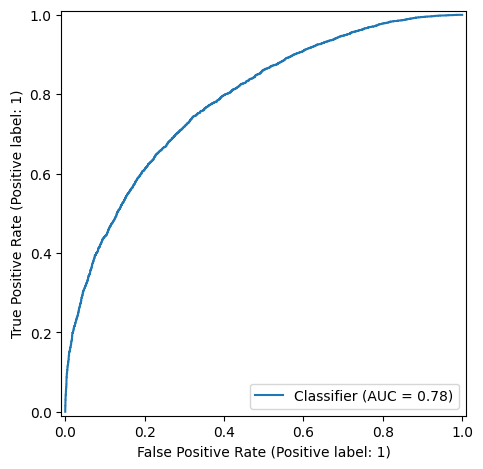

In [9]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

y_true = y_va.astype(str).values
classes = list(cm_model.classes_)  # CatBoost classes order
pos_label = "S"                    

pos_idx = classes.index(pos_label)

proba = cm_model.predict_proba(X_va)[:, pos_idx]
y_bin = (y_true == pos_label).astype(int)

auc = roc_auc_score(y_bin, proba)
print("ROC-AUC =", auc)

RocCurveDisplay.from_predictions(y_bin, proba)
plt.tight_layout()
plt.show()


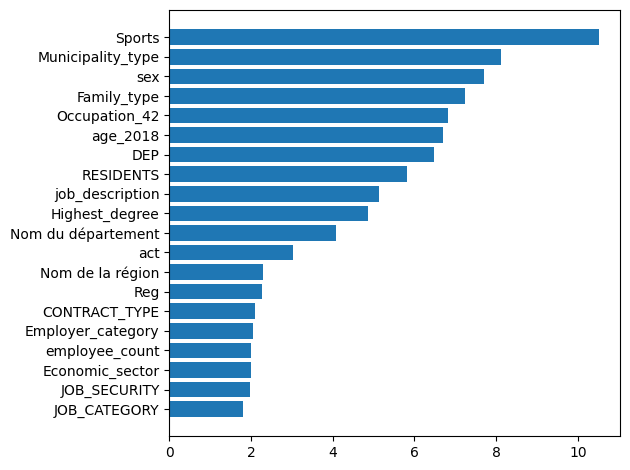

In [10]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = np.array(X_va.columns) 
imp = np.array(cm_model.get_feature_importance())

topk = 20
idx = np.argsort(imp)[-topk:]

plt.figure()
plt.barh(feature_names[idx], imp[idx])
plt.tight_layout()
plt.show()
